# Prediction analyses 

In [1]:
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import (
    partial_dependence,
    permutation_importance,
    plot_partial_dependence,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

In [2]:
current_path = os.getcwd()
dirname = current_path.split("Code")[0]
Data = dirname + "Data"
output = dirname + "Output"

In [3]:
# Import data
data = pd.read_csv(Data + "\\airbnb_newyork.csv", index_col=False)

In [4]:
data.head()
data.columns = data.columns.str.replace(' ', '').str.replace(':', '')

In [5]:
data.room_type.value_counts()

Entire/Apt    20467
Private        9457
Shared          215
Name: room_type, dtype: int64

In [6]:
data.price.describe(percentiles=[0.99])

count    30139.000000
mean       197.208467
std        919.464357
min         10.000000
50%        141.000000
99%        850.000000
max      98159.000000
Name: price, dtype: float64

<AxesSubplot:>

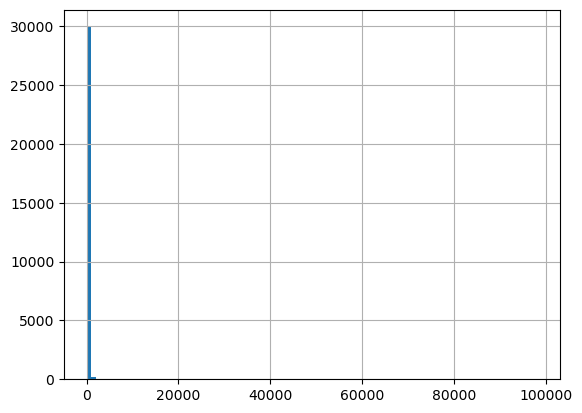

In [7]:
data.price.hist(bins=100)

In [8]:
# Remove extreme values less than 1% of data
data=data[data.price<1000.00]

<AxesSubplot:>

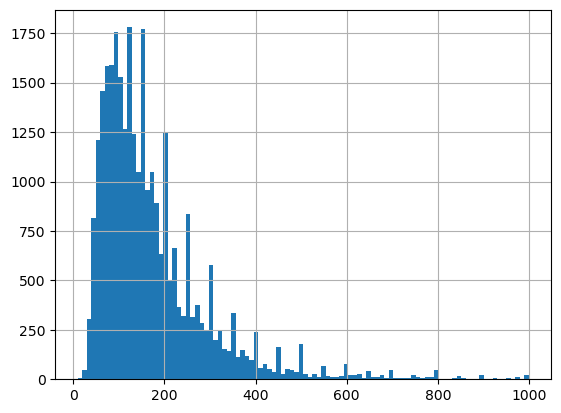

In [9]:
data.price.hist(bins=100)

In [10]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

In [11]:
data_train.shape, data_holdout.shape

((20953, 144), (8980, 144))

In [12]:
# Basic Variables
basic_vars = [
    "accommodates",
    "beds",
    "flag_days_since",
    "property_type",
    "room_type",
    "n_bathrooms",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "bedrooms",
    "has_availability",
    "instant_bookable",
    "shared_bath",
    "n_amenities", 
]

numerical=[
    "host_total_listings_count",
    "n_days_since",
    "minimum_minimum_nights",
    "number_of_reviews_l30d",
    "number_of_reviews",
    "reviews_per_month",
    "review_scores_rating",
]

ols_var=["ln_days_since",
    "ln_days_since2",
    "ln_days_since3",
    "ln_review_scores_rating",
    "ln_host_total_listings_count",
    "ln_minimum_nights",
    "ln_number_of_reviews",
    "ln_reviews_per_month",
    "ln_number_of_reviews_l30d", ]

# reviews
reviews = [
    "flag_review_scores_rating",
    "flag_reviews_per_month",
]

# Host
host = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "host_response_time",
    "flag_host_response_time",
]

# Amenities

amenities=list(data.columns[24:128].values)
# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "shared_bath:accommodates",
    "room_type:lockonbedroomdoor",
]
# with boroughs
X2 = [
    "safe:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_group_cleansed",
]

In [13]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews  + host + amenities + numerical
predictors_OLS = basic_vars + reviews + amenities + host + ols_var
predictors_E = basic_vars + reviews + amenities + host + ols_var + X1 + X2

In [14]:
#NOTE: set number of cores you want to run models
ncores = 7

### Choosing optimal model

In [15]:
# OLS regression
y, X = dmatrices("price ~ " + " + ".join(predictors_OLS), data_train)

ols_model = LinearRegression().fit(X, y)

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_OLS), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y, y_hat, squared=False)
print(ols_rmse)

y_hat_test = ols_model.predict(X_test)
ols_rmse_test = mean_squared_error(y_test, y_hat_test, squared=False)
print(ols_rmse_test)


87.14783606211633
87.23089742569523


In [16]:
# Lasso model
lasso_model = ElasticNet(l1_ratio=1, normalize=True, fit_intercept=True)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ......................alpha=0.01;, score=-88.077 total time=   2.8s
[CV 2/5] END ......................alpha=0.01;, score=-85.071 total time=   2.5s
[CV 3/5] END ......................alpha=0.01;, score=-87.079 total time=   1.5s
[CV 4/5] END ......................alpha=0.01;, score=-89.803 total time=   2.0s
[CV 5/5] END ......................alpha=0.01;, score=-92.232 total time=   5.9s
[CV 1/5] END ......................alpha=0.02;, score=-89.874 total time=   3.1s
[CV 2/5] END ......................alpha=0.02;, score=-86.866 total time=   1.5s
[CV 3/5] END ......................alpha=0.02;, score=-88.820 total time=   1.3s
[CV 4/5] END ......................alpha=0.02;, score=-91.684 total time=   1.3s
[CV 5/5] END ......................alpha=0.02;, score=-94.023 total time=   2.1s
[CV 1/5] END ......................alpha=0.03;, score=-91.647 total time=   2.1s
[CV 2/5] END ......................alpha=0.03;,

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1, normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [17]:
lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)
lasso_rmse

88.45257289617037

In [18]:
# CART
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities
cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=4.772586264496731e-05;, score=-126.578 total time=   4.9s
[CV 2/5] END ccp_alpha=4.772586264496731e-05;, score=-123.121 total time=   5.6s
[CV 3/5] END ccp_alpha=4.772586264496731e-05;, score=-123.060 total time=   4.7s
[CV 4/5] END ccp_alpha=4.772586264496731e-05;, score=-123.637 total time=   4.6s
[CV 5/5] END ccp_alpha=4.772586264496731e-05;, score=-126.634 total time=   5.2s
[CV 1/5] END .ccp_alpha=7.57553375316941e-05;, score=-121.287 total time=   5.1s
[CV 2/5] END .ccp_alpha=7.57553375316941e-05;, score=-125.532 total time=   5.2s
[CV 3/5] END .ccp_alpha=7.57553375316941e-05;, score=-122.326 total time=   5.4s
[CV 4/5] END .ccp_alpha=7.57553375316941e-05;, score=-124.714 total time=   5.0s
[CV 5/5] END .ccp_alpha=7.57553375316941e-05;, score=-123.177 total time=   4.9s
[CV 1/5] END ccp_alpha=4.772586264496731e-05;, score=-126.578 total time=   5.2s
[CV 2/5] END ccp_alpha=4.772586264496731e-05;, s

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2018),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 4.77258626e-06, 4.77258626e-06, ...,
       5.31518982e-04, 8.05734497e-04, 2.81655830e-03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [19]:
cart_rmse = (
    pd.DataFrame(cart_model_cv.cv_results_)
    .loc[lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha]
    .mean_test_score.values[0]
    * -1
)
cart_rmse

114.09717173936977

In [20]:
# Random Forest 
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {
    "max_features": [8, 10, 12],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_split=6;, score=-87.681 total time=  12.1s
[CV 2/5] END max_features=8, min_samples_split=6;, score=-83.769 total time=   1.9s
[CV 3/5] END max_features=8, min_samples_split=6;, score=-84.087 total time=   1.8s
[CV 4/5] END max_features=8, min_samples_split=6;, score=-89.309 total time=   1.8s
[CV 5/5] END max_features=8, min_samples_split=6;, score=-90.097 total time=   2.0s
[CV 1/5] END max_features=8, min_samples_split=11;, score=-87.863 total time=   1.9s
[CV 2/5] END max_features=8, min_samples_split=11;, score=-84.611 total time=   2.0s
[CV 3/5] END max_features=8, min_samples_split=11;, score=-85.547 total time=   1.6s
[CV 4/5] END max_features=8, min_samples_split=11;, score=-91.150 total time=   1.6s
[CV 5/5] END max_features=8, min_samples_split=11;, score=-91.556 total time=   1.5s
[CV 1/5] END max_features=8, min_samples_split=16;, score=-88.230 total time=   1.5s
[CV 2/5] E

In [21]:
pd.DataFrame(rf_model_1.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,8,10,12
Min_nodes,,,
5,86.99,86.27,85.47
10,88.15,87.02,86.06
15,88.42,87.39,86.60


In [50]:
model_ch= pd.DataFrame(
    {
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            cart_rmse,
            rf_model_1.cv_results_["mean_test_score"].max()*-1,
        ]
    },
    ["Reference OLS", "Lasso CV", "CART CV", "Random Forest CV"],
).round(2)
model_ch.to_csv(output +'\\model.csv', index=False)
model_ch

,RMSE
Reference OLS,87.15
Lasso CV,88.45
CART CV,114.10
Random Forest CV,85.47


### Model diagnostics 

In [23]:
rf_model_1_var_imp_df = (
    pd.DataFrame(
        rf_model_1.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)

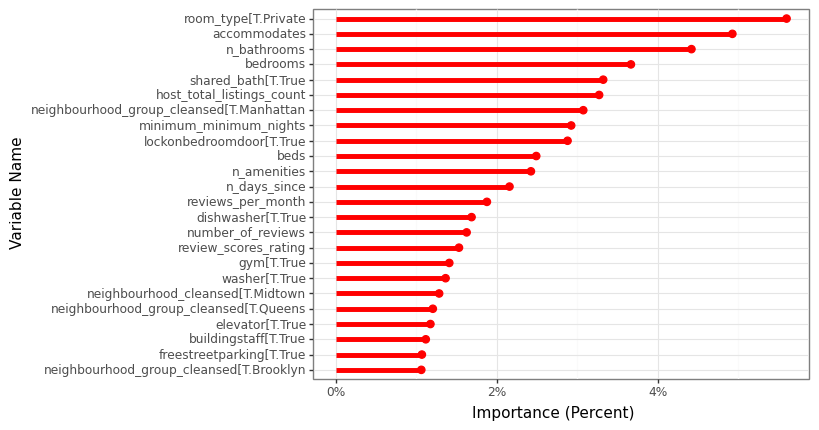

<ggplot: (114890535027)>

In [40]:
cutoff = 0.01

rf_model_1_var_imp_plot = (
    ggplot(
        rf_model_1_var_imp_df.loc[lambda x: x.imp > cutoff],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color="red", size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color="red",
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)
ggsave(rf_model_1_var_imp_plot, filename=output +'\\varimp.png', dpi=1000)
rf_model_1_var_imp_plot

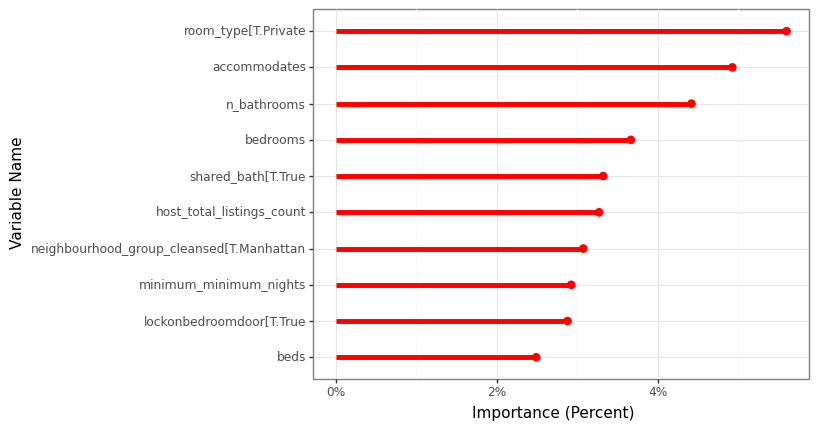

<ggplot: (114901457047)>

In [41]:
top_10= (
    ggplot(
        rf_model_1_var_imp_df.iloc[:10, :],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color="red", size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color="red",
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)
ggsave(top_10, filename=output +'\\top10.png', dpi=1000)
top_10

In [26]:
categorical_columns = [col for col in predictors_2 if data.dtypes[col]==object]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [27]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_1.best_estimator_),  # put best model to pipeline
    ]
)

In [28]:
rf_best_pipeline.fit(data_train[predictors_2], data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed',
                                                   'neighbourhood_group_cleansed',
                                                   'host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'flag_days_since',
                                                   'n_bathrooms', 'bedrooms',
                                                   'has_availability',
                                                   'instant_bookable',
                                                   'shared_b...
     

In [29]:
# This takes a while
result = permutation_importance(
    rf_best_pipeline,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [30]:
grouped = [
    "property_type", 
    "room_type",                                                
    "neighbourhood_cleansed",                  
    "minimum_minimum_nights",
    "n_days_since",
    "accommodates",
    "bedrooms",
    "shared_bath",
    "n_bathrooms",
]
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[predictors_2].columns)
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

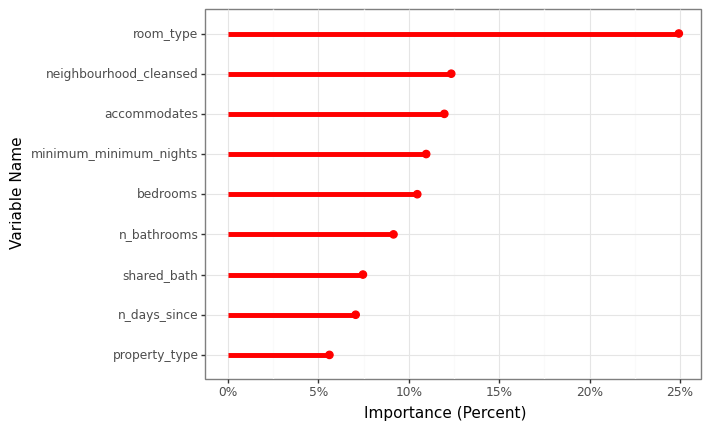

<ggplot: (114890512391)>

In [42]:
top_10grouped = (
    ggplot(
        grouped_imp,
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color="red", size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color="red",
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)
ggsave(top_10grouped, filename=output +'\\top10grouped.png', dpi=1000)
top_10grouped

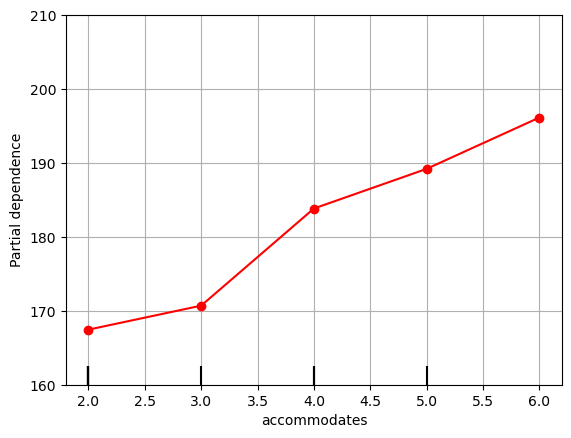

In [43]:
# Note: easy way, sklearn has plot_partial_dependence function
# we do this on holdout set!
plot_partial_dependence(
    rf_best_pipeline,
    data_holdout[predictors_2],
    ["accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": "red"},
)
plt.grid()
plt.ylim(160, 210)
plt.savefig(output +'\\accom.png')
plt.show()

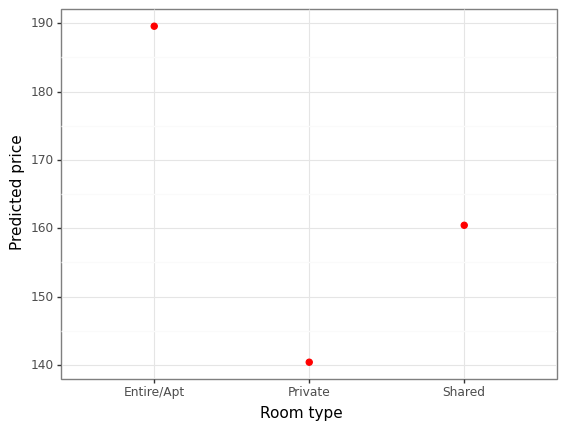

<ggplot: (114901452668)>

In [45]:
roomtype_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["room_type"], kind="average"
)

roomtype_pdp = (
    pd.DataFrame(roomtype_pdp["average"], columns=roomtype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Room type"}, axis=1)
)

room= (
    ggplot(roomtype_pdp, aes(x="Room type", y="Predicted price"))
    + geom_point(color="red", size=2)
    + scale_y_continuous( )
    + theme_bw()
)
ggsave(room, filename=output +'\\roomtype.png', dpi=1000)
room

In [34]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_best_pipeline.predict(data_holdout[predictors_2])
)

In [35]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price)
        .round(2)
    )

In [36]:
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)
grouped_object = data_holdout_w_prediction.groupby("property_type")
proptype_subset = calculate_rmse(grouped_object)

grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.neighbourhood_group_cleansed.isin(
        data.neighbourhood_group_cleansed.value_counts().index.tolist()
    )
].groupby("neighbourhood_group_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [37]:
all_holdout = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_w_prediction.price,
                data_holdout_w_prediction.predicted_price,
                squared=False,
            ),
            data_holdout_w_prediction.price.mean(),
        ],
        index=["rmse", "mean_price"],
    )
    .T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
    .round(2)
)
all_holdout.index = ["All"]

In [38]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

In [47]:
final= pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)
final.to_csv(output +'\\final.csv')
final

,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,111.17,236.52,0.47
small apt,68.18,144.71,0.47
Type,,,
condo,121.33,237.67,0.51
guest suite,58.22,138.76,0.42
home,76.34,138.69,0.55
loft,118.22,226.66,0.52
rental unit,80.27,168.96,0.48
serviced apartment,84.32,286.66,0.29
